In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import numpy as np
import pandas as pd

from rocket import Rocket

import random

In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        d = 16
        self.fc1 = nn.Linear(5, d)
        self.fc2 = nn.Linear(d, d)
        self.fc3 = nn.Linear(d, 2)
        
        a = (12/(5+d))**0.5
        nn.init.uniform_(self.fc1.weight, a=-a, b=a)
        
        a = (12/(d+d))**0.5
        nn.init.uniform_(self.fc2.weight, a=-a, b=a)
        
        a = (6/(d+2))**0.5
        nn.init.uniform_(self.fc3.weight, a=-a, b=a)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        
        return x
    
    

In [3]:
net = Net()

In [4]:
print(net)

Net(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)


In [5]:
params = list(net.parameters())

In [6]:
params;

In [7]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

402

In [8]:
class MyDataset(data.Dataset):
    
    def __init__(self, state_csv, control_csv, transform=None):
        
        df_s = pd.read_csv(state_csv)
        df_c = pd.read_csv(control_csv)
        
        #normalize by (df-mean)/std
        self.s_mean, self.s_std = df_s.mean(), df_s.std()
        self.c_mean, self.c_std = df_c.mean(), df_c.std()
        
        n_df_s = (df_s - df_s.mean())/df_s.std()
        #n_df_c = (df_c - df_c.mean())/df_c.std()
        
        #normalize control range from -1 to 1
        #self.c_max = n_df_c.max()
        #self.c_min = n_df_c.min()
        
        #n2_df_c = 2*(n_df_c-n_df_c.min())/(n_df_c.max()-n_df_c.min()) - 1
        n_df_c = df_c
        n_df_c['0'] = 2*n_df_c['0']-1 #from [0,1] to [-1,1]
        #n_df_c['1'] = 2*n_df_c['1']/np.pi #from [-pi/2, pi/2] to [-1,1]
        self.u2_nond = (np.pi/8)
        n_df_c['1'] = n_df_c['1']/self.u2_nond #from [-u2_nond, u2_nond] to [-1,1]
        #n_df_c['1'] = (n_df_c['1']-n_df_c['1'].mean())/n_df_c['1'].std()
        
        self.df_s = torch.FloatTensor(n_df_s.values)
        self.df_c = torch.FloatTensor(n_df_c.values)
        
        self.length = len(self.df_s)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        sample = {'s': self.df_s[index], 'c': self.df_c[index]}
        
        return sample
    
    def normalize_s(self, state):
        return ((state[i] - self.s_mean[i])/self.s_std[i] for i in range(5))
    
    def normalize_c(self, control):
        
        raise NotImplementedError
        
        #return ((control[i] - self.c_mean[i])/self.c_std[i] for i in range(2))
    
    def denormalize_c(self, nn_c):
        #undo the min max
        
        #n_c = [0.5*(nn_c[i]+1)*(self.c_max[i]-self.c_min[i]) + self.c_min[i] for i in range(2)]
        
        #undo the std and mean
        #c = (n_c[i]*self.c_std[i] + self.c_mean[i] for i in range(2))
        
        c1 = (nn_c[0] + 1)/2
        #c2 = (nn_c[1]*self.c_std[1] + self.c_mean[1])
        
        c2 = nn_c[1]*self.u2_nond
        
        return c1, c2
    
    def in_training_region(self, point, normalized=True):
        if normalized==False:
            point = self.normalize_s(point)
            
        for i, p in enumerate(point):
            
            if p < self.df_s[:,i].min():
                
                print(f'min: {i}')
                return False
            if p > self.df_s[:,i].max():
                print(f'max: {i}')
                return False
        
        return True
            
        

In [9]:
path_s = 'data_apollo/df_s_full.csv'
path_c = 'data_apollo/df_c_full.csv'
full_data = MyDataset(path_s, path_c)

In [10]:
train_size = int(0.95 * len(full_data))
val_size = len(full_data) - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(full_data, [train_size, val_size])

In [11]:
len(full_data)

1005131

In [12]:
len(train_dataset)

954874

In [13]:
len(validate_dataset)

50257

In [14]:
(full_data.df_s[:,0].min())*full_data.s_std[0] + full_data.s_mean[0]

tensor(-266.8588)

In [15]:
batch_size = 8
train_dl = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dl = data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)

In [16]:
train_dl

In [17]:
validate_dl

In [18]:

def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [19]:
net.zero_grad()

In [20]:

optimizer = optim.SGD(net.parameters(), lr = 0.005, momentum=0.9)
criterion = nn.MSELoss()


train_step = make_train_step(model=net, loss_fn=criterion, optimizer=optimizer)
losses = []
val_losses = []

n_epochs = 10

In [21]:
print("Started Training")
for epoch in range(n_epochs):
    episode_loss_train = 0
    episode_loss_val   = 0
    
    for batch in train_dl:

        state = batch['s']
        control = batch['c']
        
        loss = train_step(state, control)
        
        losses.append(loss)
        episode_loss_train += loss
        
    with torch.no_grad():
        for batch in validate_dl:
            
            net.eval()
            
            state = batch['s']
            control = batch['c']

            c_hat = net(state)
            
            val_loss = criterion(control, c_hat)
            
            val_losses.append(val_loss.item())
            
            episode_loss_val += val_loss.item()
            
            
    print(f"""Epoch: {epoch}, Loss: {sum(losses)/len(losses):.6f}, Val_loss: {sum(val_losses)/len(val_losses):.6f}, Epoch Loss: {episode_loss_train/len(losses):.6f}, Epoch Val Loss: {episode_loss_val/len(val_losses):.6f}""")

print('')

print("********Finished Training*********")

Started Training
Epoch: 0, Loss: 0.000522, Val_loss: 0.000184, Epoch Loss: 0.000522, Epoch Val Loss: 0.000184
Epoch: 1, Loss: 0.000334, Val_loss: 0.000153, Epoch Loss: 0.000073, Epoch Val Loss: 0.000061
Epoch: 2, Loss: 0.000259, Val_loss: 0.000134, Epoch Loss: 0.000036, Epoch Val Loss: 0.000032
Epoch: 3, Loss: 0.000216, Val_loss: 0.000121, Epoch Loss: 0.000022, Epoch Val Loss: 0.000020
Epoch: 4, Loss: 0.000188, Val_loss: 0.000110, Epoch Loss: 0.000015, Epoch Val Loss: 0.000014
Epoch: 5, Loss: 0.000167, Val_loss: 0.000103, Epoch Loss: 0.000011, Epoch Val Loss: 0.000011
Epoch: 6, Loss: 0.000152, Val_loss: 0.000097, Epoch Loss: 0.000009, Epoch Val Loss: 0.000009
Epoch: 7, Loss: 0.000141, Val_loss: 0.000092, Epoch Loss: 0.000007, Epoch Val Loss: 0.000007
Epoch: 8, Loss: 0.000131, Val_loss: 0.000088, Epoch Loss: 0.000006, Epoch Val Loss: 0.000006
Epoch: 9, Loss: 0.000123, Val_loss: 0.000084, Epoch Loss: 0.000005, Epoch Val Loss: 0.000005

********Finished Training*********


In [27]:
d = next(iter(train_dl))

In [28]:
net(d['s'])

tensor([[-3.6410e-01,  4.0233e-03],
        [-3.5908e-01,  3.0727e-03],
        [-4.6115e-01,  1.3889e-02],
        [-1.1520e-01, -9.8413e-02],
        [-3.5295e-01, -2.1899e-03],
        [-4.3839e-01,  1.3551e-02],
        [-1.0446e-04,  3.8665e-02],
        [-4.9336e-01, -2.3952e-04]], grad_fn=<TanhBackward>)

In [29]:
d['c']

tensor([[-3.6514e-01,  2.5620e-03],
        [-3.5900e-01, -5.9238e-04],
        [-4.5733e-01,  1.5833e-02],
        [-1.2200e-01, -9.6699e-02],
        [-3.5395e-01,  6.0509e-04],
        [-4.3459e-01,  1.5235e-02],
        [ 1.3405e-02,  3.1098e-02],
        [-4.9046e-01,  4.8541e-04]])

In [30]:
abs(d['c']-net(d['s']))

tensor([[1.0445e-03, 1.4613e-03],
        [7.5549e-05, 3.6651e-03],
        [3.8184e-03, 1.9441e-03],
        [6.8016e-03, 1.7135e-03],
        [1.0006e-03, 2.7950e-03],
        [3.8023e-03, 1.6840e-03],
        [1.3510e-02, 7.5668e-03],
        [2.9063e-03, 7.2493e-04]], grad_fn=<AbsBackward>)

In [32]:
torch.save(net.state_dict(), 'model.pt')

In [180]:
with torch.no_grad():
    def simulate_net(rocket, model, dataset):

        t = np.array([0,])
        dt = 1

        x, z, vx, vz, m = (np.array([s,]) for s in rocket.s_0)
        sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])

        u1, u2 = np.array([]), np.array([])
        
        while True:
            if z[-1] < 0: print('z<0'); break
            if t[-1] > 600: print('t>600'); break
            if not dataset.in_training_region(sf, normalized = False): print('minmax'); break
            sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])


            #evaluate the model
            n_sf = tuple(list(dataset.normalize_s(sf)))

            n_uf = tuple(model(torch.FloatTensor(n_sf)).detach().numpy())

            uf = tuple(list(dataset.denormalize_c(n_uf)))


            new_state = rocket.propagate(sf, uf, dt=dt)

            x = np.append(x, new_state[0])
            z = np.append(z, new_state[1])
            vx= np.append(vx, new_state[2])
            vz= np.append(vz, new_state[3])
            m = np.append(m, new_state[4])
            t = np.append(t, t[-1]+dt)

            u1 = np.append(u1, uf[0])
            u2 = np.append(u2, uf[1])


            #print(f't: {t[-1]:.1f}, x:{x[-1]:.1f}, z:{z[-1]:.1f}, u1:{u1[-1]:.2f}, u2:{u2[-1]:.2f}')

        u1 = np.append(u1, u1[-1])
        u2 = np.append(u2, u2[-1])    
            
        return (t, x, z, vx, vz, m, u1, u2)

def simulate_no_thrust(rocket):

    t = [0,]
    dt = 1

    x, z, vx, vz, m = ([s,] for s in rocket.s_0)

    u1, u2 = [], []

    while z[-1] > 0 and t[-1] < 300:
        sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])

        new_state = rocket.propagate(sf, (0,0), dt=dt)

        x.append(new_state[0])
        z.append(new_state[1])
        vx.append(new_state[2])
        vz.append(new_state[3])
        m.append(new_state[4])
        t.append(t[-1]+dt)

        u1.append(0)
        u2.append(0)


        #print(f't: {t[-1]:.1f}, x:{x[-1]:.1f}, z:{z[-1]:.1f}, u1:{u1[-1]:.2f}, u2:{u2[-1]:.2f}')
    
    u1.append(u1[-1])
    u2.append(u2[-1])   

    return (t, x, z, vx, vz, m, u1, u2)    
        

Rocket 
Initial State: (-94.96465212033995, 950.4313102743607, -1.8495310962241476, -23.028684829593658, 10478.476626536885)
max: 3
minmax


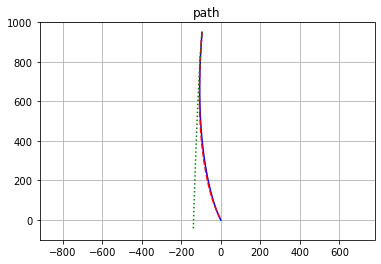

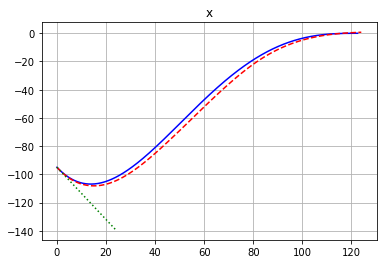

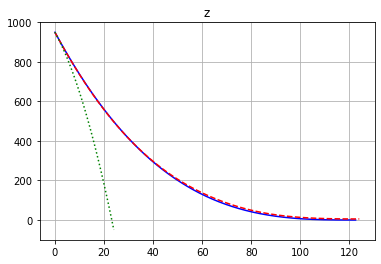

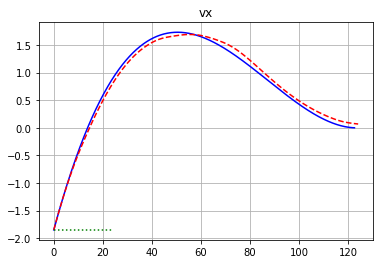

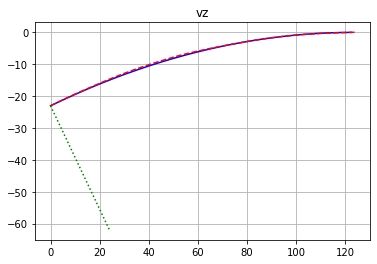

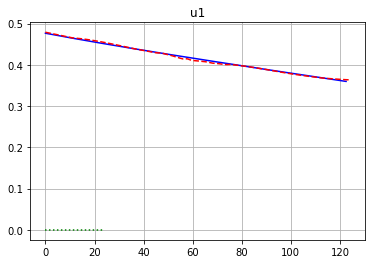

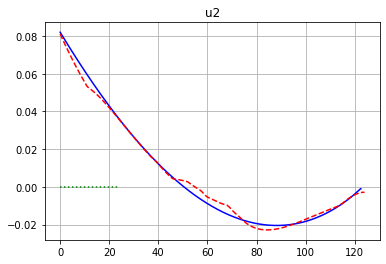

In [422]:
r = Rocket(*[150, 1700., -5, -25, 11000.], disperse=True)
r.lunar_guidance_live(h_ratio=2)
print(r)

with torch.no_grad():
    (t_net, x_net, z_net, vx_net, vz_net, m_net, u1_net, u2_net) = simulate_net(r, net, full_data)
    
(t_no, x_no, z_no, vx_no, vz_no, m_no, u1_no, u2_no) = simulate_no_thrust(r)

plt.plot(r.x, r.z, 'b-')
plt.plot(x_net, z_net, 'r--')
plt.plot(x_no, z_no, 'g:')
ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.title('path')
plt.grid()
plt.show()


plt.plot(r.t, r.x, 'b-')
plt.plot(t_net, x_net, 'r--')
plt.plot(t_no, x_no, 'g:')
plt.grid()
plt.title('x')
plt.show()

plt.plot(r.t, r.z, 'b-')
plt.plot(t_net, z_net, 'r--')
plt.plot(t_no, z_no, 'g:')
plt.grid()
plt.title('z')
plt.show()


plt.plot(r.t, r.vx, 'b-')
plt.plot(t_net, vx_net, 'r--')
plt.plot(t_no, vx_no, 'g:')
plt.grid()
plt.title('vx')
plt.show()


plt.plot(r.t, r.vz, 'b-')
plt.plot(t_net, vz_net, 'r--')
plt.plot(t_no, vz_no, 'g:')
plt.grid()
plt.title('vz')
plt.show()



plt.plot(r.t, r.u1_mag, 'b-')
plt.plot(t_net, u1_net, 'r--')
plt.plot(t_no, u1_no, 'g:')
plt.grid()
plt.title('u1')
plt.show()


plt.plot(r.t, r.u2_angle, 'b-')
plt.plot(t_net, u2_net, 'r--')
plt.plot(t_no, u2_no, 'g:')
plt.grid()
plt.title('u2')
plt.show()


In [162]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

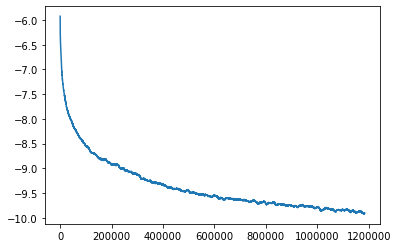

In [163]:
plt.plot(np.log(moving_average(losses[1:],10000)))

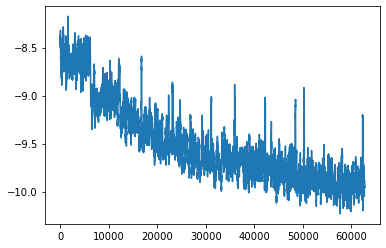

In [164]:
plt.plot(np.log(moving_average(val_losses,100)))

In [165]:
net(train_dataset[0]['s'])

tensor([-0.4044, -0.0094], grad_fn=<TanhBackward>)

In [166]:
train_dataset[0]['c']

tensor([-0.4048, -0.0103])

In [167]:
for i in range(10):
    print(net(train_dataset[i]['s']), train_dataset[i]['c'])

tensor([-0.4044, -0.0094], grad_fn=<TanhBackward>) tensor([-0.4048, -0.0103])
tensor([-0.4668,  0.0065], grad_fn=<TanhBackward>) tensor([-0.4639,  0.0061])
tensor([-0.2781,  0.0162], grad_fn=<TanhBackward>) tensor([-0.2806,  0.0181])
tensor([-0.3448,  0.0083], grad_fn=<TanhBackward>) tensor([-0.3446,  0.0048])
tensor([-0.3831,  0.0015], grad_fn=<TanhBackward>) tensor([-3.8533e-01,  2.3858e-04])
tensor([-0.4114, -0.0024], grad_fn=<TanhBackward>) tensor([-0.4038, -0.0103])
tensor([-0.4179,  0.0112], grad_fn=<TanhBackward>) tensor([-0.4164,  0.0124])
tensor([-0.4706,  0.0013], grad_fn=<TanhBackward>) tensor([-0.4681,  0.0029])
tensor([-0.3931,  0.0060], grad_fn=<TanhBackward>) tensor([-0.3927,  0.0061])
tensor([-0.2830,  0.0152], grad_fn=<TanhBackward>) tensor([-0.2828,  0.0144])


In [427]:
def tensor_dynamics(state, dt = 1):
    x = state[0]
    z = state[1]
    vx = state[2]
    vz = state[3]
    m = state[4]
    
    #non dimensionalize
    n_state = (state - torch.tensor(full_data.s_mean))/torch.tensor(full_data.s_std)
    
    # predict using net
    u = net.forward(n_state)
    
    #de-normalize
    u1 = (u[0] + 1)/2
    u2 = (u[1]*np.pi/8)
    
    #dynamics
    g = 1.6229
    c1 = 44000
    c2 = 311*9.81
    
    dx = vx
    dz = vz
    dvx = c1*(u1/m)*torch.sin(u2)
    dvz = c1*(u1/m)*torch.cos(u2) - g
    dm  = -(c1/c2)*u1
    
    #update state
    x = x + dx*dt
    z = z + dz*dt
    vx = vx + dvx*dt
    vz = vz + dvz*dt
    m = m + dm*dt
    
    #return new state
    new_state = torch.stack((x, z, vx, vz, m))
    
    return new_state
    
    

In [428]:
torch.tensor(full_data.s_mean)

tensor([-4.8342e-01,  3.4932e+02,  1.7036e-03, -5.6301e+00,  9.1971e+03])

In [429]:
r = Rocket()
state = torch.tensor(r.s_0, requires_grad=True)

In [430]:
state

tensor([ 1.3267e+02,  1.3430e+03,  6.0173e+00, -1.9112e+01,  1.0071e+04],
       requires_grad=True)

In [431]:
state = tensor_dynamics(state)

tensor([ 2.0658,  2.3424,  4.7130, -2.2336,  0.6898], grad_fn=<DivBackward0>)


In [432]:
state

tensor([ 1.3868e+02,  1.3239e+03,  5.7809e+00, -1.8839e+01,  1.0065e+04],
       grad_fn=<StackBackward>)

In [423]:
def forward_simulate_net(rocket, model, dataset):
        
        t = 0
        dt = 1
        
        state = torch.tensor(r.s_0, requires_grad=True)
        
        m0 = state[4]
        
        landed = False
        
        while True:
            if state[1] < 0: 
                print('z<0');
                landed = True; 
                break
            if t > 1000:
                print('t>1000'); break
            #if not dataset.in_training_region(sf, normalized = False): print('minmax'); break
            if landed:
                break

            state = tensor_dynamics(state, dt) #updates state
            t += dt
            
            #check for landing
            fin_dist = (state[0]**2 + state[1]**2)**0.5
            fin_velo = (state[2]**2 + state[3]**2)**0.5
            
            if fin_dist < 10 and fin_velo < 0.7:
                landed = True
                return 1 - state[4]/m0 #return propellant mass usage
        
        ## compute losses
        #if its here, it didnt succeed
        
        print('landing failed')
        return fin_dist/10 + fin_velo/0.7

In [425]:

r = Rocket()
print(forward_simulate_net(r, net, full_data))

tensor(1685.0354, grad_fn=<PowBackward0>)
tensor(1687.5605, grad_fn=<PowBackward0>)
tensor(1690.0343, grad_fn=<PowBackward0>)
tensor(1692.4552, grad_fn=<PowBackward0>)
tensor(1694.8226, grad_fn=<PowBackward0>)
tensor(1697.1355, grad_fn=<PowBackward0>)
tensor(1699.3929, grad_fn=<PowBackward0>)
tensor(1701.5942, grad_fn=<PowBackward0>)
tensor(1703.7384, grad_fn=<PowBackward0>)
tensor(1705.8252, grad_fn=<PowBackward0>)
tensor(1707.8535, grad_fn=<PowBackward0>)
tensor(1709.8230, grad_fn=<PowBackward0>)
tensor(1711.7329, grad_fn=<PowBackward0>)
tensor(1713.5829, grad_fn=<PowBackward0>)
tensor(1715.3722, grad_fn=<PowBackward0>)
tensor(1717.1005, grad_fn=<PowBackward0>)
tensor(1718.7671, grad_fn=<PowBackward0>)
tensor(1720.3713, grad_fn=<PowBackward0>)
tensor(1721.9127, grad_fn=<PowBackward0>)
tensor(1723.3907, grad_fn=<PowBackward0>)
tensor(1724.8049, grad_fn=<PowBackward0>)
tensor(1726.1548, grad_fn=<PowBackward0>)
tensor(1727.4402, grad_fn=<PowBackward0>)
tensor(1728.6605, grad_fn=<PowBack

tensor(1006.5472, grad_fn=<PowBackward0>)
tensor(1001.4599, grad_fn=<PowBackward0>)
tensor(996.3687, grad_fn=<PowBackward0>)
tensor(991.2740, grad_fn=<PowBackward0>)
tensor(986.1759, grad_fn=<PowBackward0>)
tensor(981.0746, grad_fn=<PowBackward0>)
tensor(975.9703, grad_fn=<PowBackward0>)
tensor(970.8633, grad_fn=<PowBackward0>)
tensor(965.7537, grad_fn=<PowBackward0>)
tensor(960.6415, grad_fn=<PowBackward0>)
tensor(955.5272, grad_fn=<PowBackward0>)
tensor(950.4107, grad_fn=<PowBackward0>)
tensor(945.2928, grad_fn=<PowBackward0>)
tensor(940.1744, grad_fn=<PowBackward0>)
tensor(935.0563, grad_fn=<PowBackward0>)
tensor(929.9393, grad_fn=<PowBackward0>)
tensor(924.8240, grad_fn=<PowBackward0>)
tensor(919.7114, grad_fn=<PowBackward0>)
tensor(914.6021, grad_fn=<PowBackward0>)
tensor(909.4969, grad_fn=<PowBackward0>)
tensor(904.3964, grad_fn=<PowBackward0>)
tensor(899.3016, grad_fn=<PowBackward0>)
tensor(894.2130, grad_fn=<PowBackward0>)
tensor(889.1312, grad_fn=<PowBackward0>)
tensor(884.057

tensor(252.9375, grad_fn=<PowBackward0>)
tensor(253.0122, grad_fn=<PowBackward0>)
tensor(253.1044, grad_fn=<PowBackward0>)
tensor(253.2139, grad_fn=<PowBackward0>)
tensor(253.3400, grad_fn=<PowBackward0>)
tensor(253.4824, grad_fn=<PowBackward0>)
tensor(253.6407, grad_fn=<PowBackward0>)
tensor(253.8144, grad_fn=<PowBackward0>)
tensor(254.0032, grad_fn=<PowBackward0>)
tensor(254.2066, grad_fn=<PowBackward0>)
tensor(254.4242, grad_fn=<PowBackward0>)
tensor(254.6557, grad_fn=<PowBackward0>)
tensor(254.9007, grad_fn=<PowBackward0>)
tensor(255.1587, grad_fn=<PowBackward0>)
tensor(255.4294, grad_fn=<PowBackward0>)
tensor(255.7125, grad_fn=<PowBackward0>)
tensor(256.0075, grad_fn=<PowBackward0>)
tensor(256.3141, grad_fn=<PowBackward0>)
tensor(256.6319, grad_fn=<PowBackward0>)
tensor(256.9606, grad_fn=<PowBackward0>)
tensor(257.2999, grad_fn=<PowBackward0>)
tensor(257.6493, grad_fn=<PowBackward0>)
tensor(258.0086, grad_fn=<PowBackward0>)
tensor(258.3775, grad_fn=<PowBackward0>)
tensor(258.7555,

tensor(369.9551, grad_fn=<PowBackward0>)
tensor(370.7234, grad_fn=<PowBackward0>)
tensor(371.4941, grad_fn=<PowBackward0>)
tensor(372.2674, grad_fn=<PowBackward0>)
tensor(373.0432, grad_fn=<PowBackward0>)
tensor(373.8214, grad_fn=<PowBackward0>)
tensor(374.6020, grad_fn=<PowBackward0>)
tensor(375.3851, grad_fn=<PowBackward0>)
tensor(376.1706, grad_fn=<PowBackward0>)
tensor(376.9584, grad_fn=<PowBackward0>)
tensor(377.7487, grad_fn=<PowBackward0>)
tensor(378.5413, grad_fn=<PowBackward0>)
tensor(379.3363, grad_fn=<PowBackward0>)
tensor(380.1336, grad_fn=<PowBackward0>)
tensor(380.9333, grad_fn=<PowBackward0>)
tensor(381.7352, grad_fn=<PowBackward0>)
tensor(382.5395, grad_fn=<PowBackward0>)
tensor(383.3460, grad_fn=<PowBackward0>)
tensor(384.1548, grad_fn=<PowBackward0>)
tensor(384.9659, grad_fn=<PowBackward0>)
tensor(385.7792, grad_fn=<PowBackward0>)
tensor(386.5946, grad_fn=<PowBackward0>)
tensor(387.4124, grad_fn=<PowBackward0>)
tensor(388.2323, grad_fn=<PowBackward0>)
tensor(389.0544,

tensor(590.5427, grad_fn=<PowBackward0>)
tensor(591.7656, grad_fn=<PowBackward0>)
tensor(592.9860, grad_fn=<PowBackward0>)
tensor(594.2036, grad_fn=<PowBackward0>)
tensor(595.4183, grad_fn=<PowBackward0>)
tensor(596.6302, grad_fn=<PowBackward0>)
tensor(597.8391, grad_fn=<PowBackward0>)
tensor(599.0449, grad_fn=<PowBackward0>)
tensor(600.2475, grad_fn=<PowBackward0>)
tensor(601.4468, grad_fn=<PowBackward0>)
tensor(602.6428, grad_fn=<PowBackward0>)
tensor(603.8353, grad_fn=<PowBackward0>)
tensor(605.0244, grad_fn=<PowBackward0>)
tensor(606.2098, grad_fn=<PowBackward0>)
tensor(607.3916, grad_fn=<PowBackward0>)
tensor(608.5698, grad_fn=<PowBackward0>)
tensor(609.7441, grad_fn=<PowBackward0>)
tensor(610.9146, grad_fn=<PowBackward0>)
tensor(612.0812, grad_fn=<PowBackward0>)
tensor(613.2440, grad_fn=<PowBackward0>)
tensor(614.4026, grad_fn=<PowBackward0>)
tensor(615.5573, grad_fn=<PowBackward0>)
tensor(616.7078, grad_fn=<PowBackward0>)
tensor(617.8542, grad_fn=<PowBackward0>)
tensor(618.9966,

In [394]:
r = Rocket()
print(forward_simulate_net(r, net, full_data))

KeyboardInterrupt: 

In [395]:
optimizer.zero_grad()

In [396]:
losses = []

n_epochs = 1

print("Started Training v2")
for epoch in range(n_epochs):
    episode_loss_train = 0
    episode_loss_val   = 0
    
    for _ in range(10):

        r = Rocket(disperse=True)
        print(r)
        
        #set into training mode
        net.train()
        
        #forward simulate
        loss = forward_simulate_net(r, net, full_data)
        print(loss)
        
        loss.backward()
        
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        episode_loss_train += loss.item()
            
            
    print(f"""Epoch: {epoch}, Loss: {sum(losses)/len(losses):.6f}, Epoch Loss: {episode_loss_train/len(losses):.6f}""")

print('')

print("********Finished Training*********")

Started Training v2
Rocket 
Initial State: (-140.40922669637337, 1253.2836917199716, -5.11461117173412, -10.805206502834032, 10459.808012838896)


ValueError: could not determine the shape of object type 'Series'

In [388]:
r = Rocket(disperse=True)
print(r)

#set into training mode
net.train()

#forward simulate
loss = forward_simulate_net(r, net, full_data)
print(loss)


Rocket 
Initial State: (-10.974005457097405, 548.4856180812819, 3.5778150433477123, 0.6574677104951512, 9428.518664854597)
z<0


NameError: name 'x' is not defined

In [ ]:
loss.backward()

In [ ]:
optimizer.step()
optimizer.zero_grad()

In [397]:
optimizer.zero_grad()